### Text Content Models
In this notebook we will use the decision content itself for authorship detection. Two methods will be used:<br>
1. RandomForest, LinearSVC, and MultinomialNB on CountVectorizer feature extraction<br>
2. cosine similarity using word count, tf-idf, and word embedding.<br>


In [1]:
import csv
import numpy as np
import pandas as pd
import re
import spacy
import random

from collections import Counter
from pathlib import Path

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    multilabel_confusion_matrix, 
    plot_confusion_matrix, 
    ConfusionMatrixDisplay
)

# gensim imports
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
from gensim.similarities import SoftCosineSimilarity
from gensim.models import Word2Vec, KeyedVectors

# nltk imports

# visualization imports
from wordcloud import WordCloud

from utils.utils import print_full
from utils.classification import (
    add_names,
    calculate_similarities_count,
    calculate_similarities_embed,
    calculate_similarities_tfidf,
    chart_per_curiams,
    chart_results,
    closest_value,
    get_best_accuracy_model,
    get_classification_report,
    get_classification_report,
    get_mean_accuracy_model,
    most_similar,
    predict_per_curiams,
    run_100,
    run_and_display_model_values,
    run_cross_validation,
    run_n_times,
)


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
base_data_path = Path.cwd() / 'data'
csv_path = base_data_path / 'csv'

similarity_csv = csv_path / 'similarity.csv'
authored_engineered_data_csv = csv_path / 'authored_engineered_data.csv'
curiam_engineered_data_csv = csv_path / 'curiam_engineered_data.csv'
curiam_similarity_csv = csv_path / 'curiam_similarity.csv'       # has justice as separate column  use for RF
authored_similarity_csv = csv_path / 'authored_similarity.csv'   # has justice as separate column   use for RF

In [3]:
similarity_df = pd.read_csv(similarity_csv)

authored_engineered_df = pd.read_csv(authored_engineered_data_csv)
curiam_engineered_df = pd.read_csv(curiam_engineered_data_csv)

authored_sim_df = pd.read_csv(authored_similarity_csv)
curiam_sim_df = pd.read_csv(curiam_similarity_csv)

### Setup
here we setup the dataframes, feature columns, and target column

In [4]:
authored_engineered_df = pd.read_csv(authored_engineered_data_csv)
authored_engineered_df = authored_engineered_df[['text','justice']].copy()
authored_engineered_df['justice_name'] = authored_engineered_df['justice']
authored_engineered_df['justice'] = pd.factorize(authored_engineered_df['justice'])[0]

# create justice_names map
justice_names = authored_engineered_df.justice_name.unique().tolist()
justice_int = authored_engineered_df.justice.unique().tolist()
justices_map = dict(zip(justice_int, justice_names))

# Classification feature/target configruation
X = authored_engineered_df.text
y = authored_engineered_df.justice

# create the CountVectorizer and fit the data
vec = CountVectorizer(ngram_range=(1,3))
X = vec.fit_transform(X)

##### the curiam decisions have to be transformed to align with the fitted data. We do this an drop it into an np array

In [5]:
curiam_transformed_df = pd.read_csv(curiam_engineered_data_csv)
curiam_transformed_data = vec.transform(curiam_transformed_df.text)

##### accuracy and classification is stored in dataframes for later reference

In [6]:
accuracy_columns = ['Classifier', 'Mean Accuracy', 'Best Accuracy']
accuracy_summary_df = pd.DataFrame(columns=accuracy_columns)

classification_columns = ['Classifier']
classification_columns.extend(sorted(justice_names))
mean_classification_df = pd.DataFrame(columns=classification_columns)
best_classification_df = pd.DataFrame(columns=classification_columns)

### Process
We are going to use three models: LinearSVC, RandomForest, and MultinomialNB:
1. perform 50 runs and collect the avg accuracy and best accuracy<br>
2. add data to accuracy_summary_df<br>
3. chart the accuracy distribution<br>
4. as opposed to the feature classification notebook, we will not perform cross validation.<br>
5. classify the per curiam decisions by the avg and best accuracy<br>
6. add data to avg_classification_df and best_classification_df<br>

finally, we wll display the dataframes

### LinearSVC

#### 1) 50 runs

In [7]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_n_times(X=X, y=y, model='LinearSVC', runs=50)

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['LinearSVC', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.65
ACCURACY STD: 0.0481
HIGHEST ACCURACY: 0.7361


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,65.0,73.61


#### 2) chart the accuracy distribution

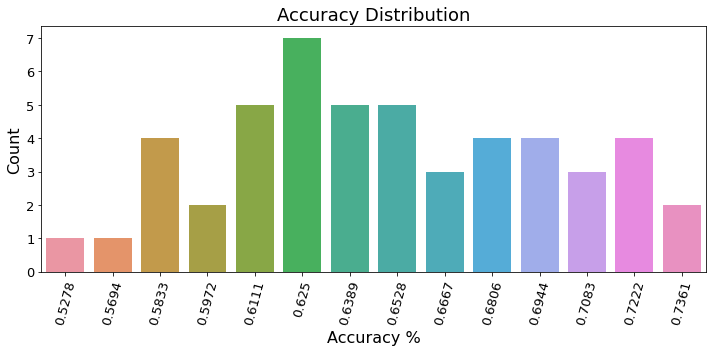

In [8]:
chart_results(accuracy_score_list)

#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [9]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, avg_model, 'LinearSVC', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.6527777777777778
index of closest accuracy score: 11
closest accuracy score found 5 times
indexes: [11 12 20 30 39]
choosing model from index: 12


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,8,0,1,0,22,0,1,0,3


In [10]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, best_model, 'LinearSVC', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [ 4 27]
max accuracy: 4
choosing model from index: 0.7361111111111112


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,9,0,1,0,18,1,3,1,2


### Random Forest


#### 1) 50 runs

In [11]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_n_times(X=X, y=y, model='RandomForest', runs=50)

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['RandomForest', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.6361
ACCURACY STD: 0.0524
HIGHEST ACCURACY: 0.7639


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,65.00,73.61
0,RandomForest,63.61,76.39


#### 2) chart the accuracy distribution

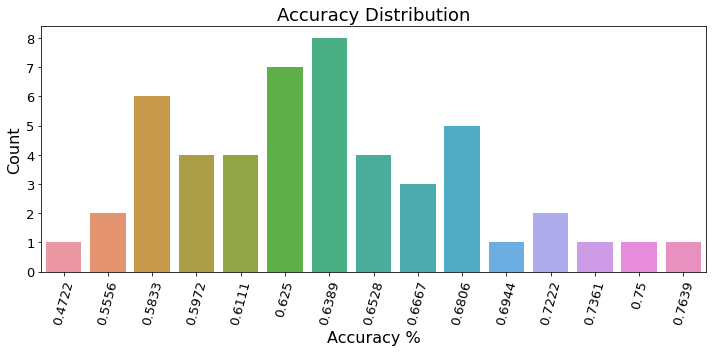

In [12]:
chart_results(accuracy_score_list)

#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [13]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, avg_model, 'RandomForest', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.6388888888888888
index of closest accuracy score: 2
closest accuracy score found 8 times
indexes: [ 2  5 14 17 18 29 35 37]
choosing model from index: 14


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,8,0,1,0,22,0,1,0,3
0,RandomForest,0,0,23,0,1,9,0,0,2


In [14]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, best_model, 'RandomForest', justice_names, justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [41]
max accuracy: 41
choosing model from index: 0.7638888888888888


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,9,0,1,0,18,1,3,1,2
0,RandomForest,0,0,12,0,2,21,0,0,0


### MultinomialNB

#### 1) 50 runs

In [22]:
# get average accuracy, accuracy stdev, and highest accuracy for 100 LinearSVC runs
highest_accuracy_score, accuracy_score_list, best_model, model_sets, models_dict = run_n_times(X=X, y=y, model='MultinomialNB', runs=50)

mean_accuracy = round(np.average(accuracy_score_list),4)
highest_accuracy = round(float(highest_accuracy_score),4)

tmp_df = pd.DataFrame([['MultinomialNB', mean_accuracy*100, highest_accuracy*100]], columns=accuracy_columns)
accuracy_summary_df = accuracy_summary_df.append(tmp_df)
accuracy_summary_df

AVERAGE ACCURACY: 0.3011
ACCURACY STD: 0.0434
HIGHEST ACCURACY: 0.4306


,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,65.00,73.61
0,RandomForest,63.61,76.39
0,MultinomialNB,30.11,43.06


#### 2) chart the accuracy distribution

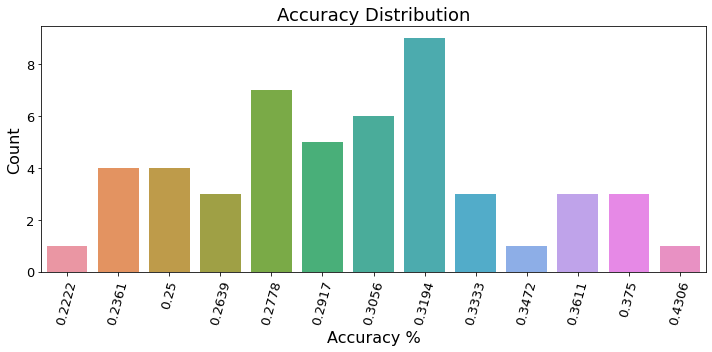

In [23]:
chart_results(accuracy_score_list)

#### 3) predict per curiam decisions based on avg and best models from the 100 model run
1. first, we get the accuracy value that is closest to the average<br>
2. second, we get a list of all indexes that have that accuracy value<br>
3. third, randomly choose index value and get corresponding model<br>
4. fourth, classify curiam decisions by that model<br>

In [24]:
avg_model = get_mean_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, avg_model, 'MultinomialNB', justice_names, justices_map)
mean_classification_df = mean_classification_df.append(tmp_df)
mean_classification_df

closest accuracy score: 0.3055555555555556
index of closest accuracy score: 6
closest accuracy score found 6 times
indexes: [ 6  8 11 24 43 47]
choosing model from index: 24


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,8,0,1,0,22,0,1,0,3
0,RandomForest,0,0,23,0,1,9,0,0,2
0,MultinomialNB,13,0,0,1,20,1,0,0,0


In [25]:
best_model = get_best_accuracy_model(accuracy_score_list, models_dict)
tmp_df = predict_per_curiams(curiam_engineered_df, curiam_transformed_data, best_model, 'MultinomialNB', justice_names,
                             justices_map)
best_classification_df = best_classification_df.append(tmp_df)
best_classification_df

indexes: [0]
max accuracy: 0
choosing model from index: 0.4305555555555556


,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,9,0,1,0,18,1,3,1,2
0,RandomForest,0,0,12,0,2,21,0,0,0
0,MultinomialNB,12,0,0,1,20,0,0,2,0


### Cosine Similarity
Run cosine similarity on extracted text. This will be done on three different text representations:<br>
&nbsp; &nbsp; &nbsp; &nbsp; 1) word frequenty <br>
&nbsp; &nbsp; &nbsp; &nbsp; 2) tf-df<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3) word embedding. we will use goolge provided w2v vectors and custom vectors built solely from the text of the decision data<br>

In [26]:
# load data
all_decisions_df = pd.read_csv(similarity_csv)

#### By word frequency

In [27]:
identifiers = all_decisions_df.identifier.tolist()
decisions = all_decisions_df.text.tolist()

In [28]:
count_sim_array = calculate_similarities_count(data=decisions)
count_sim_df = most_similar(documents=identifiers, sim_array=count_sim_array)
count_sim_df.most_similar_justice = count_sim_df.most_similar_justice.apply(lambda x: x.split(':')[1])
count_sim_df.identifier = count_sim_df.identifier.apply(lambda x: x.split(':')[0])

In [29]:
# each document has high similarity with multiple documents. We'll get back to this
count_sim_df

,identifier,most_similar_justice,similarity_score
0,case-562-594,Thomas,0.685703
1,case-562-594,Ginsburg,0.680951
2,case-562-594,Alito,0.652795
3,case-568-17,Ginsburg,0.674142
4,case-568-17,Thomas,0.671948
...,...,...,...
100,case-577-14-10008,Thomas,0.430864
101,case-577-14-10008,Sotomayor,0.419109
102,case-577-14-1143,Alito,0.692457
103,case-577-14-1143,Alito,0.584555


#### By tf-idf

In [30]:
tfidf_sim_array = calculate_similarities_tfidf(data=decisions)
tfidf_sim_df = most_similar(documents=identifiers, sim_array=tfidf_sim_array)
tfidf_sim_df.most_similar_justice = tfidf_sim_df.most_similar_justice.apply(lambda x: x.split(':')[1])
tfidf_sim_df.identifier = tfidf_sim_df.identifier.apply(lambda x: x.split(':')[0])

In [31]:
# these results are REALLY bad; not work exploring any further
tfidf_sim_df

,identifier,most_similar_justice,similarity_score
0,case-562-594,Alito,0.127944
1,case-562-594,Roberts,0.126964
2,case-562-594,Thomas,0.126552
3,case-568-17,Ginsburg,0.094226
4,case-568-17,Scalia,0.089307
...,...,...,...
100,case-577-14-10008,Kennedy,0.057970
101,case-577-14-10008,Thomas,0.057734
102,case-577-14-1143,Alito,0.205443
103,case-577-14-1143,Alito,0.123560


#### By Word Embedding
first we need to add a unicode column for the text. then we will run the google and custom vectors

In [32]:
all_decisions_df['text_unicode'] = all_decisions_df.apply(lambda x: [token for token in simple_preprocess(x.text,
                                                                                                       min_len=0,
                                                                                                       max_len=float("inf"))], axis=1
                                                                                                      )

##### using Google generated word vectors

In [33]:
embed_sim_df = calculate_similarities_embed(gdf=all_decisions_df)
embed_sim_df

100%|██████████| 21953/21953 [01:36<00:00, 227.11it/s]


starting enumerate
working on number: 0
working on number: 25
working on number: 50
working on number: 75
working on number: 100
working on number: 125
working on number: 150
working on number: 175
working on number: 200
working on number: 225
working on number: 250
working on number: 275
working on number: 300
working on number: 325
working on number: 350
working on number: 375


,case,most_similar,similarity_score,avg_similarity,score_avg_difference
0,case-562-594:unknown,case-578-14-8349:Thomas,0.5557,0.2534,0.3023
1,case-568-17:unknown,case-577-15-648:unknown,0.3838,0.1943,0.1895
2,case-574-21:unknown,case-568-313:Sotomayor,0.4070,0.1964,0.2106
3,case-577-14-848:unknown,case-571-263:unknown,0.2742,0.1193,0.1549
4,case-575-14-939:unknown,case-563-493:Alito,0.3597,0.1797,0.1800
...,...,...,...,...,...
390,case-564-786:Scalia,case-564-786:Alito,0.7858,0.2379,0.5479
391,case-576-13-628:Scalia,case-566-189:Roberts,0.7033,0.2204,0.4829
392,case-572-489:Scalia,case-576-14-46:Kagan,0.7167,0.1840,0.5327
393,case-576-14-114:Scalia,case-576-14-114:Roberts,0.8614,0.2613,0.6001


In [34]:
embed_sim_df.head(35)

,case,most_similar,similarity_score,avg_similarity,score_avg_difference
0,case-562-594:unknown,case-578-14-8349:Thomas,0.5557,0.2534,0.3023
1,case-568-17:unknown,case-577-15-648:unknown,0.3838,0.1943,0.1895
2,case-574-21:unknown,case-568-313:Sotomayor,0.4070,0.1964,0.2106
3,case-577-14-848:unknown,case-571-263:unknown,0.2742,0.1193,0.1549
4,case-575-14-939:unknown,case-563-493:Alito,0.3597,0.1797,0.1800
5,case-562-1:unknown,case-577-14-449:Scalia,0.5576,0.2650,0.2926
6,case-575-14-593:unknown,case-565-400:Scalia,0.5690,0.2168,0.3522
7,case-577-15-648:unknown,case-578-14-8349:Thomas,0.5292,0.2140,0.3152
8,case-565-520:unknown,case-566-650:unknown,0.3050,0.1484,0.1566
9,case-578-15-723:unknown,case-566-156:Kennedy,0.2118,0.1027,0.1091


##### These are really bad as well. Let's use the custom generated word vectors

In [35]:
custom_embed_sim_df = calculate_similarities_embed(gdf=all_decisions_df, vectors=True)
custom_embed_sim_df

100%|██████████| 21953/21953 [00:00<00:00, 23420.52it/s] 


starting enumerate
working on number: 0
working on number: 25
working on number: 50
working on number: 75
working on number: 100
working on number: 125
working on number: 150
working on number: 175
working on number: 200
working on number: 225
working on number: 250
working on number: 275
working on number: 300
working on number: 325
working on number: 350
working on number: 375


,case,most_similar,similarity_score,avg_similarity,score_avg_difference
0,case-562-594:unknown,case-565-520:unknown,0.4686,0.0868,0.3818
1,case-568-17:unknown,case-563-333:Scalia,0.2240,0.0463,0.1777
2,case-574-21:unknown,case-569-597:Ginsburg,0.2063,0.0579,0.1484
3,case-577-14-848:unknown,case-571-263:unknown,0.1887,0.0280,0.1607
4,case-575-14-939:unknown,case-566-318:Kennedy,0.1815,0.0520,0.1295
...,...,...,...,...,...
390,case-564-786:Scalia,case-564-786:Alito,0.8379,0.0908,0.7471
391,case-576-13-628:Scalia,case-566-189:Roberts,0.6103,0.0830,0.5273
392,case-572-489:Scalia,case-576-14-46:Kagan,0.6378,0.0662,0.5716
393,case-576-14-114:Scalia,case-576-14-114:Roberts,0.8259,0.1000,0.7259


#### get most similar justice by simple word count

In [36]:
# the only one worth futher investigation is the frequency count
# let's get the top 20 documents for each and work with that
count20_sim_array = calculate_similarities_count(data=decisions)
top_20_count_by_case_df = most_similar(documents=identifiers, sim_array=count20_sim_array, num_highest=20)
top_20_count_by_case_df.most_similar_justice = top_20_count_by_case_df.most_similar_justice.apply(lambda x: x.split(':')[1])
top_20_count_by_case_df.identifier = top_20_count_by_case_df.identifier.apply(lambda x: x.split(':')[0])

In [37]:
### view the data by how many times a justice was matched
results_df = top_20_count_by_case_df.groupby('most_similar_justice').agg({'most_similar_justice': ['count']}).round(2)
results_df.columns = [col[1] for col in results_df.columns.values]
results_df.reset_index(level=0, inplace=True)
results_df.rename(columns={'most_similar_justice': 'justice'}, inplace=True)
results_df

,justice,count
0,Alito,77
1,Breyer,40
2,Ginsburg,89
3,Kagan,60
4,Kennedy,77
5,Roberts,61
6,Scalia,135
7,Sotomayor,98
8,Thomas,63


#### and the visuals

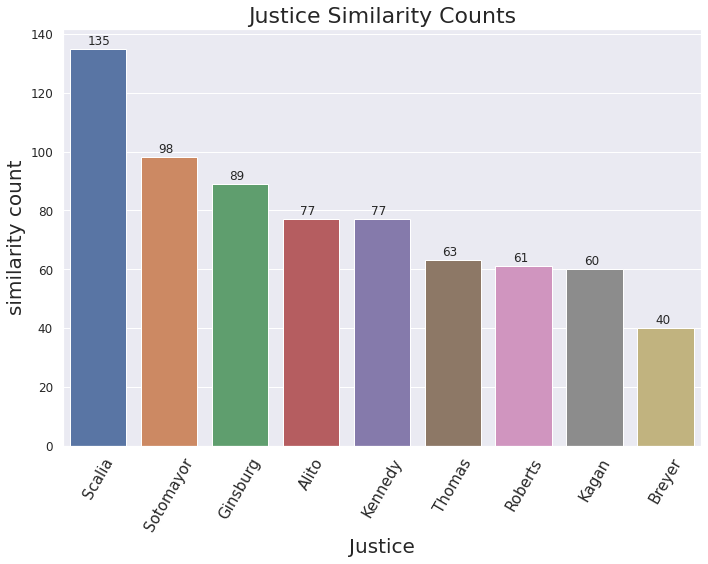

In [38]:
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["figure.autolayout"] = True
ax = sns.countplot(x="most_similar_justice", data=top_20_count_by_case_df, 
                 order = top_20_count_by_case_df.most_similar_justice.value_counts().index)

for p in ax.patches:
   ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+1.5))

ax.set_xlabel('Justice',fontsize=20)
ax.set_ylabel('similarity count',fontsize=20)
ax.set_title('Justice Similarity Counts',fontsize=22)

plt.xticks(rotation=60, size=15)
plt.yticks(size=12)
plt.show()

#### Most similar allocations
here we get the top 20 document matches per per curiam. The we total how many there are per justice

In [39]:
most_similar_identifier_view_df = pd.crosstab(top_20_count_by_case_df.identifier,    
                 top_20_count_by_case_df.most_similar_justice)

In [40]:
most_similar_identifier_view_df

most_similar_justice,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
identifier,,,,,,,,,
case-562-1,1,0,3,3,2,2,5,2,2
case-562-216,2,0,4,2,2,3,4,1,2
case-562-594,1,1,5,1,1,3,3,4,1
case-565-1,2,1,2,2,3,1,4,4,1
case-565-23,4,0,1,1,1,1,5,6,1
case-565-388,1,2,3,2,4,1,3,1,3
case-565-469,7,4,0,0,0,2,4,3,0
case-565-520,3,2,3,1,0,2,4,4,1
case-565-65,0,1,4,2,2,3,4,3,1


##### charting this would be quite complex and a bit confusing, so just a few observations:
1. slightly more than half of the per curiams, 18, have all 9 justices matching at least one time.
2. not one per curiam has a single justice accounting for more than half the matches
3. a quick scan of the data shows that many of the per curiams have a fairly even distribution across justices.

#### now let's look at the justice level instead of the document level.
we will combine all of the documents per justice into a single document and rerun the similary by word count. We do this because the tfidf and word embedding similarities have very poor results and are not really worth further investigation.

In [41]:
authored_decisions_df = pd.read_csv(authored_similarity_csv)

In [44]:
authored_decisions_df.head()

,case,justice,text,identifier
0,case-565-452,Kagan,federal meat inspection act fmia act usc et se...,case-565-452:Kagan
1,case-575-13-1019,Kagan,sue employer discrimination equal employment o...,case-575-13-1019:Kagan
2,case-578-15-339,Kagan,prison reform act plra inmate exhaust quoted_t...,case-578-15-339:Kagan
3,case-564-319,Kagan,consider sentencing reform act preclude federa...,case-564-319:Kagan
4,case-573-351,Kagan,provision federal bank usc make criminal know ...,case-573-351:Kagan


In [42]:
# first copy the identifer and text columns for all per curiam decisions
cur_df = all_decisions_df[all_decisions_df.identifier.str.contains('unknown')][['identifier','text']].copy()

# now combine all the texts for each justice and dump into new datafram
justices = authored_decisions_df.justice.unique()
new_texts = list()
author_combined_text_df = pd.DataFrame()
author_combined_text_df['identifier'] = justices
for justice in justices:
    texts = authored_decisions_df[authored_decisions_df.justice == justice]['text'].tolist()
    texts = [x.replace('quoted_text', '') for x in texts]
    new_texts.append(' '.join(texts))

author_combined_text_df['text'] = new_texts
author_combined_text_df.identifier = author_combined_text_df.identifier.apply(lambda x: f'{x}:{x}')

# finally, concat the dataframes
dataframes = [cur_df, author_combined_text_df]
combined_decisions = pd.concat(dataframes)
combined_decisions = combined_decisions.reset_index(drop=True)
combined_decisions.text = combined_decisions.text.str.replace('quoted_text', '')

identifiers = combined_decisions.identifier.tolist()
decisions = combined_decisions.text.tolist()

In [44]:
count_combined_sim_array = calculate_similarities_count(data=decisions)
count_combined_sim_df = most_similar(documents=identifiers, sim_array=count_combined_sim_array, num_highest=9)
count_combined_sim_df.most_similar_justice = count_combined_sim_df.most_similar_justice.apply(lambda x: x.split(':')[1])
count_combined_sim_df.identifier = count_combined_sim_df.identifier.apply(lambda x: x.split(':')[0])

##### let look as the justice similarity score rankings for the first two document to get a sense of what the data looks like

In [45]:
count_combined_sim_df.head(18)

,identifier,most_similar_justice,similarity_score
0,case-562-594,Ginsburg,0.577192
1,case-562-594,Kennedy,0.556237
2,case-562-594,Alito,0.526234
3,case-562-594,Scalia,0.510318
4,case-562-594,Thomas,0.501556
5,case-562-594,Roberts,0.493542
6,case-562-594,Sotomayor,0.491099
7,case-562-594,Breyer,0.484749
8,case-562-594,Kagan,0.483628
9,case-568-17,Ginsburg,0.664019


##### how to summarize this?
we will summarize this data by providing a score for the similarity score for each justice: 9 for 1st, 8 for 2nd, 7 for 3rd, and so on. We will then total the value for each justice across all 35 per curiam decisions. This is a bit crude but it can give us an idea how how each justice ranks across all 40 document

In [65]:
rank_score = {0:9, 1:8, 2:7, 3:6, 4:5, 5:4, 6:3, 7:2, 8:1 }
justice_idx = dict()
justice_scores = dict()
rank_dict = dict()

# loop through the justices and get their dataframe index values
for name in justice_names:
    justice_idx[name] = count_combined_sim_df.index[count_combined_sim_df['most_similar_justice']==name].tolist()

# now lets loop through the dict and calculate the score for each justice
for name, indexes in justice_idx.items():
    justice_scores[name] = sum([rank_score[x % 9] for x in indexes])

# create the dataframe
justice = justice_scores.keys()
scores = justice_scores.values()
rank_dict['justice'] = justice
rank_dict['score'] = scores
rank_df = pd.DataFrame.from_dict(rank_dict)

# now lets sort it by score in descending order
rank_df.sort_values(by='score', ascending = False, inplace=True)
rank_df

,justice,score
4,Kennedy,287
5,Ginsburg,263
2,Alito,239
8,Scalia,212
1,Sotomayor,159
3,Thomas,153
6,Roberts,105
0,Kagan,103
7,Breyer,54


##### now let's plot it to get a visual

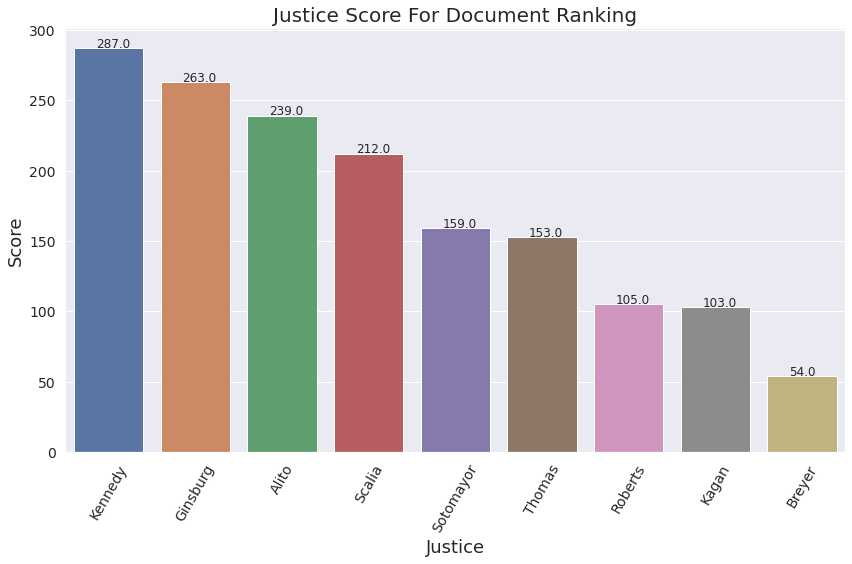

In [66]:
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='score', x="justice", data = rank_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Justice',fontsize=18)
ax.set_ylabel('Score',fontsize=18)
ax.set_title('Justice Score For Document Ranking',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

#### analysis
again, this is a bit crude, but it does give a sense of how highly each justice ranked across all 35 per curiam decisions. We see that Kennedy ranked fairly high across the decisions and Beryer ranked fairly low. We can get an average for each justice and plot that as well

In [70]:
rank_df['avg_rank'] = round(rank_df['score'] / 35, 4)
rank_df

,justice,score,avg_rank
4,Kennedy,287,8.2000
5,Ginsburg,263,7.5143
2,Alito,239,6.8286
8,Scalia,212,6.0571
1,Sotomayor,159,4.5429
3,Thomas,153,4.3714
6,Roberts,105,3.0000
0,Kagan,103,2.9429
7,Breyer,54,1.5429


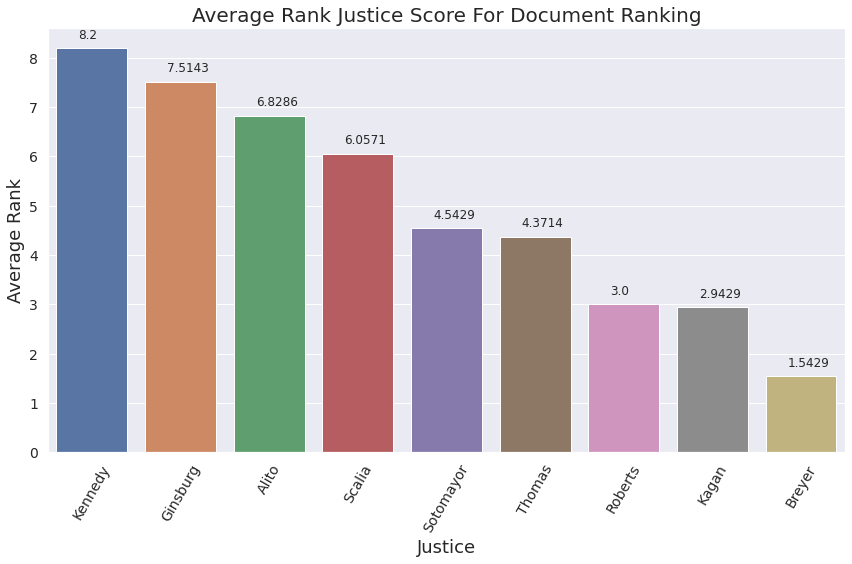

In [74]:
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='avg_rank', x="justice", data = rank_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.2))

ax.set_xlabel('Justice',fontsize=18)
ax.set_ylabel('Average Rank',fontsize=18)
ax.set_title('Average Rank Justice Score For Document Ranking',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

#### analysis
1. we can rank these into 4 tiers: Kennedy through Scalia; Sotomayor and Thomas; Roberts and Kagan; and Breyer
2. Kennedy does really well with an 8.2 average ranking (out of a possible 9)
3. one would think this would be conclusive, but it is not, given the data above. We can also look at a few decisions and see that there is not a single justice that stands out

In [76]:
# first let's get a random sample of the cases
case_list = curiam_engineered_df.case.tolist()
sample_cases = random.sample(case_list, 20)

# now let's group the data by case
grouped_by_identifier_df = count_combined_sim_df.groupby('identifier')

cases_df_dict = dict()
for case in sample_cases:
    cases_df_dict[case] = grouped_by_identifier_df.get_group(case)

In [77]:
def display_case(df, case_name):
    sns.set(color_codes=True)
    plt.rcParams["figure.figsize"] = [7,5]
    plt.rcParams["figure.autolayout"] = True
    ax = sns.barplot(x="most_similar_justice", y="similarity_score", data=df)

    ax.set_xlabel('Justice',fontsize=16)
    ax.set_ylabel('Similarity',fontsize=16)
    ax.set_title(f'Similarty Scores for Case:  {case_name}',fontsize=18)

    plt.xticks(rotation=60, size=15)
    plt.yticks(size=12)
    plt.show()

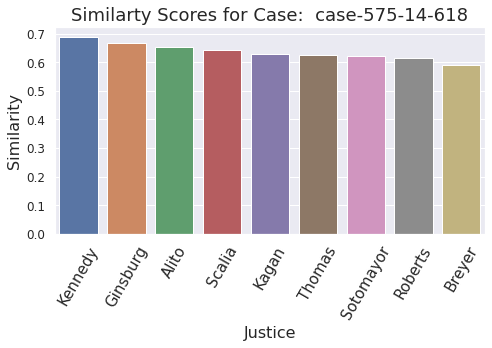

In [81]:
display_case(cases_df_dict[sample_cases[1]],sample_cases[1])

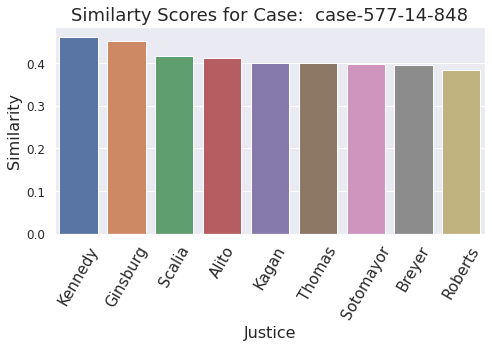

In [82]:
display_case(cases_df_dict[sample_cases[2]],sample_cases[2])

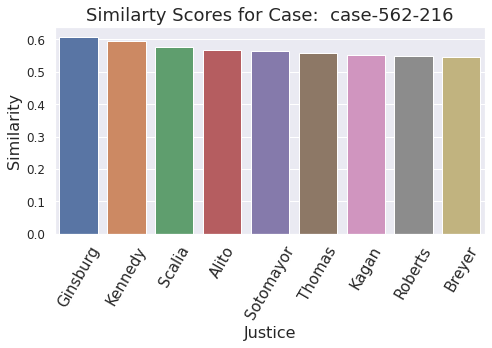

In [84]:
display_case(cases_df_dict[sample_cases[10]],sample_cases[10])

#### cursory analysis
1. there is a significant variation in the similarities across justices at the document level.
2. the similarity scores do not vary much within the documents themselves.

#### Investigating the similarities
Since the similarity scores are done by word count and they are quite similar, let's look at the top 25 word counts for each justice. I suspect we will find the lists are highly similar.

In [85]:
# similarities are extremely high; likely that even now a lot of the vocabulary between justices is the same
justice_dict = dict()
justice_list = list()
words_list = list()
counts_list = list()
position_list = list()
layout_dict = dict()
all_words = list()

wc_df = pd.DataFrame()
for j,t in zip(justices,new_texts):
    justice_dict[j] = t
    
for justice in justices:
    txt = justice_dict[justice]
    word_freq = Counter(txt.split())
    most_common = word_freq.most_common(25)
    layout_dict[justice] = [x[0] for x in most_common]
    all_words.extend([x[0] for x in most_common])
    
all_words_frequency = Counter(all_words)
awf_words =[x[0] for x in all_words_frequency.items()]
awf_count = [x[1] for x in all_words_frequency.items()]
wf_df = pd.DataFrame.from_dict({'word' : awf_words, 'frequency': awf_count})

for justice in justices:
    wc_df[justice] = layout_dict[justice]

In [86]:
wc_df = pd.DataFrame()
for justice in justices:
    wc_df[justice] = layout_dict[justice]
wc_df

,Kagan,Sotomayor,Alito,Thomas,Kennedy,Ginsburg,Roberts,Breyer,Scalia
0,court,court,court,court,court,court,court,court,court
1,u_s,u_s,u_s,u_s,u_s,u_s,u_s,u_s,u_s
2,federal,versus,versus,versus,versus,versus,versus,versus,versus
3,versus,state,case,federal,state,state,federal,federal,state
4,state,federal,state,law,case,federal,state,act,federal
5,case,case,federal,state,federal,case,law,law,law
6,government,law,law,case,law,law,case,state,case
7,law,congress,states,states,rule,states,government,case,act
8,congress,states,united,rule,states,act,act,district,states
9,states,majority,act,opinion,united,united,states,government,opinion


##### just looking at the top 5 or 6 words for each justice, we see that they are almost the same. This is a good explanation for the similarity scoress
We can also chart them to get a visual sense of how similar the vocabularies are.

In [87]:
wf_df = pd.DataFrame.from_dict({'word' : awf_words, 'frequency': awf_count})
wf_df = wf_df.sort_values(by=['frequency'], ascending=False)
wf_df = wf_df.reset_index(drop=True)

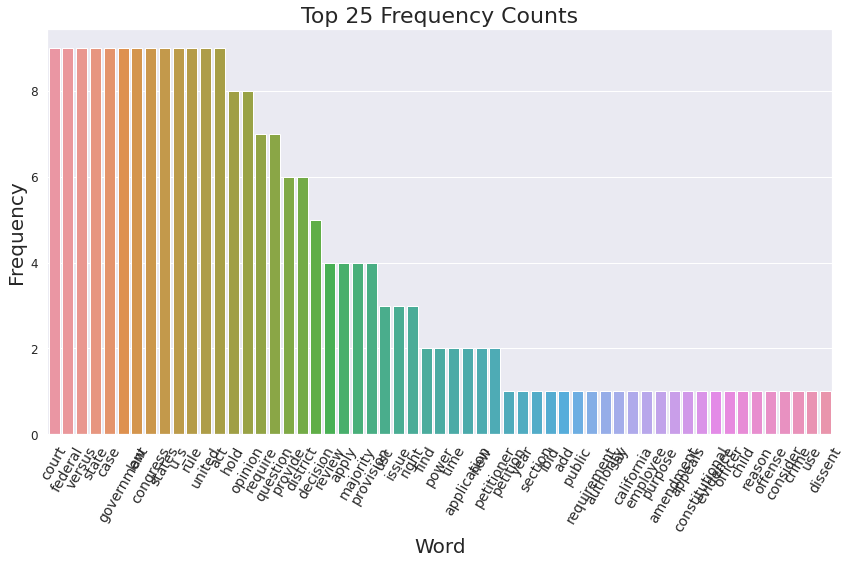

In [88]:
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(x="word", y="frequency", data=wf_df)

ax.set_xlabel('Word',fontsize=20)
ax.set_ylabel('Frequency',fontsize=20)
ax.set_title('Top 25 Frequency Counts',fontsize=22)

plt.xticks(rotation=60, size=14)
plt.yticks(size=12)
plt.show()

##### so, 17 words occur 6 or more times in the top 25 lists. This indicates a highly similar vocabulary across the justices

### Visualizations for classifications
At this point we have 3 dataframes with summary/aggregate information. We can get a visual sense of that data.

In [89]:
accuracy_summary_df

,Classifier,Mean Accuracy,Best Accuracy
0,LinearSVC,65.00,73.61
0,RandomForest,63.61,76.39
0,MultinomialNB,30.11,43.06


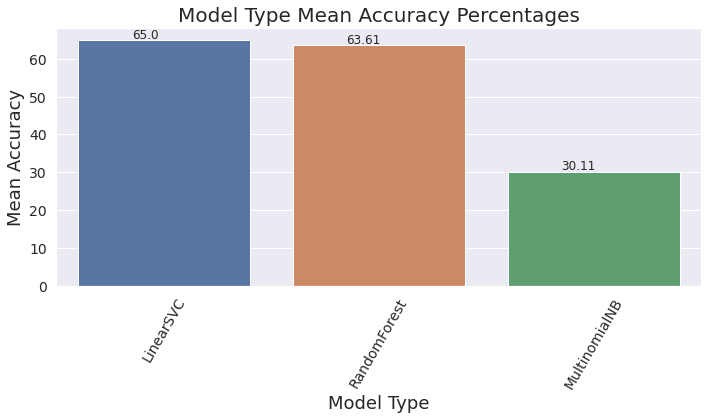

In [90]:
asd_by_mean_df = accuracy_summary_df.sort_values(by='Mean Accuracy', ascending = False)
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='Mean Accuracy', x="Classifier", data = asd_by_mean_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Model Type',fontsize=18)
ax.set_ylabel('Mean Accuracy',fontsize=18)
ax.set_title('Model Type Mean Accuracy Percentages',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

##### LinearSVC and RandomForest are very close in average accuracy, while MultinomialNB scored very poorly

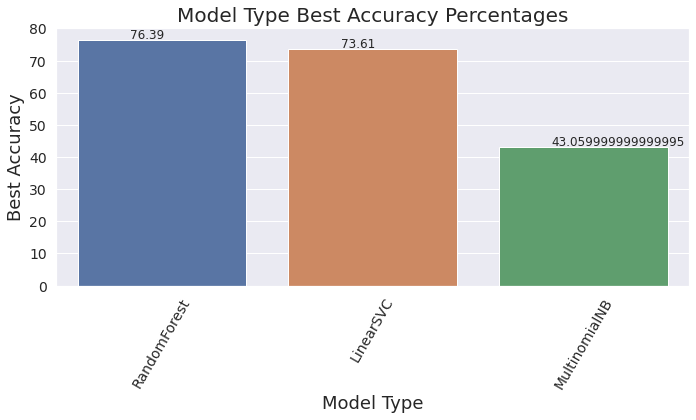

In [91]:
asd_by_best_df = accuracy_summary_df.sort_values(by='Best Accuracy', ascending = False)
plt.rcParams["figure.figsize"] = [10,6]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(y='Best Accuracy', x="Classifier", data = asd_by_best_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+.5))

ax.set_xlabel('Model Type',fontsize=18)
ax.set_ylabel('Best Accuracy',fontsize=18)
ax.set_title('Model Type Best Accuracy Percentages',fontsize=20)

plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

##### the same is true for the best accuracy averages. This is what I would expect.

#### We can visualize the per curiam classifications by model type (avg, best) or classifier name
There are three in total, and viewing comparisons could get tricky.. The dataframe view shows the large differences in how the per curiams were classified

In [92]:
mean_classification_df

,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,8,0,1,0,22,0,1,0,3
0,RandomForest,0,0,23,0,1,9,0,0,2
0,MultinomialNB,13,0,0,1,20,1,0,0,0


In [93]:
best_classification_df

,Classifier,Alito,Breyer,Ginsburg,Kagan,Kennedy,Roberts,Scalia,Sotomayor,Thomas
0,LinearSVC,9,0,1,0,18,1,3,1,2
0,RandomForest,0,0,12,0,2,21,0,0,0
0,MultinomialNB,12,0,0,1,20,0,0,2,0


### Discussion
There is much more analysis that could be done on the results of the data. The above is a good start and helps in drawing conclusions about the text classification efforts.<br><br> Classifying the per curiams by text only was no better than classifying them by features only. I was quite surprised by this as I expected the classifications to be somewhat better. The cosine similary results were equally surprising. As discussed in the presentation, the close similarity scores among the justices can indicate that the justices are, in fact, quite similar to each other, at least when it comes to writing Court decisions. This makes some sense as the documents have the following two features:<br>
1. highly stuctured format<br>
2. high frequency of legal terms and entities<br><br>